<a href="https://colab.research.google.com/github/Siqi-Fang/Vehicles_Prediction_TS/blob/main/Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Problem Statement
[Acknowledgement](https://www.kaggle.com/vetrirah/ml-iot)
##Context
You are working with the government to transform your city into a smart city. The vision is to convert it into a digital and intelligent city to improve the efficiency of services for the citizens. One of the problems faced by the government is traffic. You are a data scientist working to manage the traffic of the city better and to provide input on infrastructure planning for the future.

The government wants to implement a robust traffic system for the city by being prepared for traffic peaks. They want to understand the **traffic patterns of the four junctions of the city**. **Traffic patterns on holidays, as well as on various other occasions during the year, differ from normal working days.** This is important to take into account for your forecasting.

##Content
To predict traffic patterns in each of these four junctions for the next 4 months.

The sensors on each of these junctions were collecting data at different times, hence you will see traffic data from different time periods. To add to the complexity, some of the junctions have provided limited or sparse data requiring thoughtfulness when creating future projections. Depending upon the historical data of 20 months, the government is looking to you to deliver accurate traffic projections for the coming four months. Your algorithm will become the foundation of a larger transformation to make your city smart and intelligent.

#Analysis
##Packages

In [ ]:
# pip install statsmodels

In [ ]:
# Data Manipulation:
import numpy as np
import pandas as pd

# Data Viz :
import matplotlib.pyplot as plt
import seaborn as sns 
# Machine Learning 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
  # metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
  # models
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
# Time Series 
from datetime import datetime 

##Load Dataset

See acknowledgment for data source.

In [ ]:
train_path = '/content/drive/MyDrive/Colab Notebooks/TS_IOT/train_ML_IOT.csv'
test_path = '/content/drive/MyDrive/Colab Notebooks/TS_IOT/test_ML_IOT.csv'

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

##Basic Data Info

In [ ]:
# Python Method 1 : Displays Data Information :
"""
def display_data_information(data, data_types, dataframe_name):
    print(" Information of ",dataframe_name,": Rows = ",data.shape[0],"| Columns = ",data.shape[1],"\n")
    data.info()
    print("\n")
    for VARIABLE in data_types :
        data_type = data.select_dtypes(include=[ VARIABLE ]).dtypes
        if len(data_type) > 0 :
            print(str(len(data_type))+" "+VARIABLE+" Features\n"+str(data_type)+"\n"  )        

data_types  = ["float32","float64","int32","int64","object","category","datetime64[ns]"]
"""

'\ndef display_data_information(data, data_types, dataframe_name):\n    print(" Information of ",dataframe_name,": Rows = ",data.shape[0],"| Columns = ",data.shape[1],"\n")\n    data.info()\n    print("\n")\n    for VARIABLE in data_types :\n        data_type = data.select_dtypes(include=[ VARIABLE ]).dtypes\n        if len(data_type) > 0 :\n            print(str(len(data_type))+" "+VARIABLE+" Features\n"+str(data_type)+"\n"  )        \n\ndata_types  = ["float32","float64","int32","int64","object","category","datetime64[ns]"]\n'

In [ ]:
# display data information of training set 
#display_data_information(train, data_types, "Train")

 Information of  Train : Rows =  48120 | Columns =  4 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DateTime  48120 non-null  object
 1   Junction  48120 non-null  int64 
 2   Vehicles  48120 non-null  int64 
 3   ID        48120 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


3 int64 Features
Junction    int64
Vehicles    int64
ID          int64
dtype: object

1 object Features
DateTime    object
dtype: object



The time intervals are 1 hr. The data range from 2015-11-01 to 2017-06-30.
Junction: category and number of Vehicles are documented. 

In [ ]:
# display some sample entries
train.head(3).append(train.tail(3))

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
48117,2017-06-30 21:00:00,4,16,20170630214
48118,2017-06-30 22:00:00,4,22,20170630224
48119,2017-06-30 23:00:00,4,12,20170630234


In [ ]:
train.describe()

,Junction,Vehicles,ID
count,48120.000000,48120.000000,4.812000e+04
mean,2.180549,22.791334,2.016330e+10
std,0.966955,20.750063,5.944854e+06
min,1.000000,1.000000,2.015110e+10
25%,1.000000,9.000000,2.016042e+10
50%,2.000000,15.000000,2.016093e+10
75%,3.000000,29.000000,2.017023e+10
max,4.000000,180.000000,2.017063e+10


In [ ]:
train.DateTime.describe()

count                   48120
unique                  14592
top       2017-06-30 23:00:00
freq                        4
Name: DateTime, dtype: object

##Basic Data Cleaning

###Check for duplicated entries between train and test

In [ ]:
# prevents data leakage
# diff = pd.merge(test,train, how='outer')
# diff[diff['ID'].duplicated()].count()

Drop ID columns

In [ ]:
train.drop(['ID'], axis = 1, inplace=True)
test.drop(['ID'], axis = 1, inplace=True)

### Handle Missing Values

In [ ]:
# train.isna().any()

###Transform DateTime 

In [ ]:
train['DateTime'] = pd.to_datetime(train['DateTime'])
test['DateTime'] = pd.to_datetime(test['DateTime'])

train.set_index('DateTime')
test.set_index('DateTime')

,Junction
DateTime,
2017-07-01 00:00:00,1
2017-07-01 01:00:00,1
2017-07-01 02:00:00,1
2017-07-01 03:00:00,1
2017-07-01 04:00:00,1
...,...
2017-10-31 19:00:00,4
2017-10-31 20:00:00,4
2017-10-31 21:00:00,4


##A First Look at Our Target Variable

###Difference Across Time Frequencies

In [ ]:
"""
# Resampling to daily frequency
train_day = train.resample('D').mean()

# Resampling to monthly frequency
train_month = train.resample('M').mean()

# Resampling to annual frequency
train_year = train.resample('A-DEC').mean()

# Resampling to quarterly frequency
train_Q = train.resample('Q-DEC').mean()

In [ ]:
"""
train_hour = train[train.index < 
                   pd.to_datetime('2015-11-03')].resample('H').mean()
train_hour.head()

,Vehicles
DateTime,
2015-11-01 00:00:00,10.000000
2015-11-01 01:00:00,8.666667
2015-11-01 02:00:00,6.666667
2015-11-01 03:00:00,4.666667
2015-11-01 04:00:00,6.000000


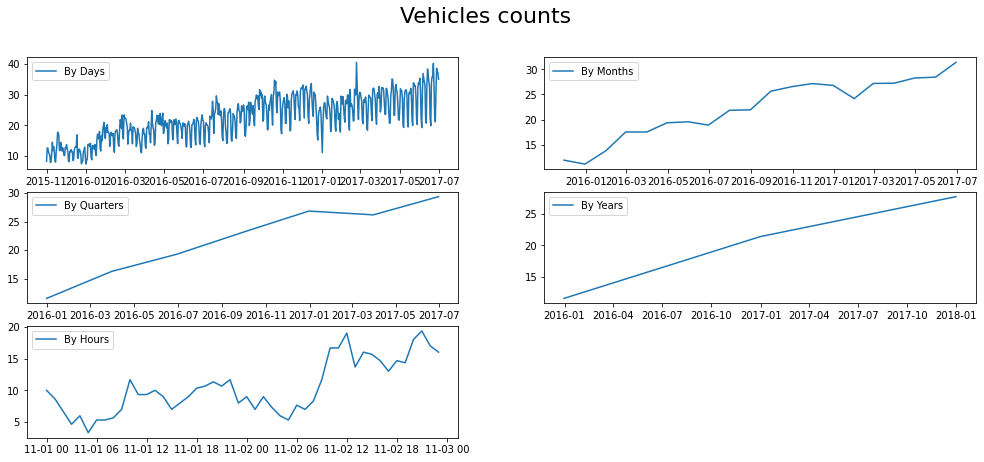

In [ ]:
# PLOTS
"""
fig = plt.figure(figsize=[17, 7])
plt.suptitle('Vehicles counts', fontsize=22)

plt.subplot(325)
plt.plot(train_hour.Vehicles, '-', label='By Hours')
plt.legend()

plt.subplot(321)
plt.plot(train_day.Vehicles, '-', label='By Days')
plt.legend()

plt.subplot(322)
plt.plot(train_month.Vehicles, '-', label='By Months')
plt.legend()

plt.subplot(323)
plt.plot(train_Q.Vehicles, '-', label='By Quarters')
plt.legend()

plt.subplot(324)
plt.plot(train_year.Vehicles, '-', label='By Years')
plt.legend()


# plt.tight_layout()
plt.show()
"""

### Difference Across Junctions
As stated in the prompt each junction collect data differently, so we graph the data collected in each junction to see how much they differ and decide if we should model each differently.


In [ ]:
# create different df for each junction
train_j1 = train[train['Junction']==1].copy()
train_j2 = train[train['Junction']==2].copy()
train_j3 = train[train['Junction']==3].copy()
train_j4 = train[train['Junction']==4].copy()

train_j1.drop(['Junction'],axis=1,inplace=True)
train_j2.drop(['Junction'],axis=1,inplace=True)
train_j3.drop(['Junction'],axis=1,inplace=True)
train_j4.drop(['Junction'],axis=1,inplace=True)

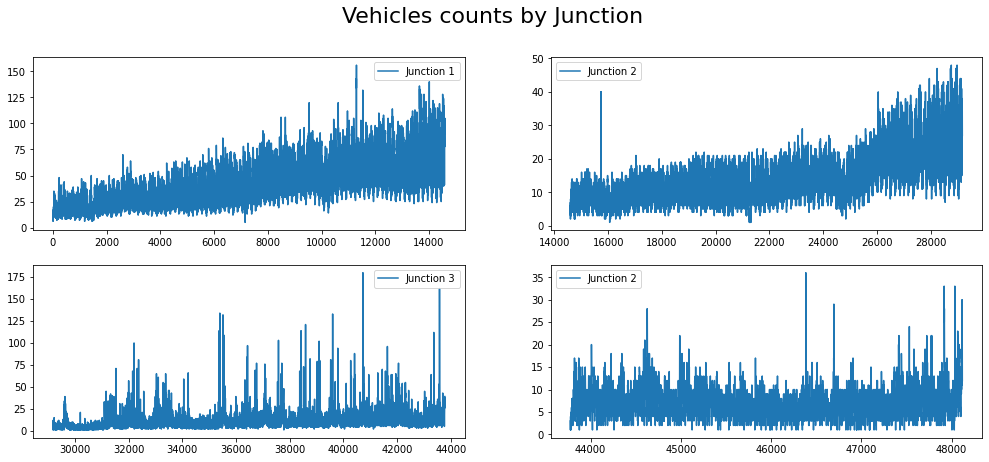

In [ ]:
# Plot the data for each model 
"""
fig = plt.figure(figsize=[17, 7])
plt.suptitle('Vehicles counts by Junction', fontsize=22)

plt.subplot(221)
plt.plot(train_j1.Vehicles, '-', label='Junction 1')
plt.legend()

plt.subplot(222)
plt.plot(train_j2.Vehicles, '-', label='Junction 2')
plt.legend()

plt.subplot(223)
plt.plot(train_j3.Vehicles, '-', label='Junction 3')
plt.legend()

plt.subplot(224)
plt.plot(train_j4.Vehicles, '-', label='Junction 2')
plt.legend()

plt.show()

 Since the data differ without certain pattern, we will do forecasting for each junction seperately. 

We need to also split the test data.

In [ ]:
# Split test data by junctions
test_j1 = test[test['Junction']==1].copy()
test_j2 = test[test['Junction']==2].copy()
test_j3 = test[test['Junction']==3].copy()
test_j4 = test[test['Junction']==4].copy()

test_j1.drop(['Junction'],axis=1,inplace=True)
test_j2.drop(['Junction'],axis=1,inplace=True)
test_j3.drop(['Junction'],axis=1,inplace=True)
test_j4.drop(['Junction'],axis=1,inplace=True)

##Feature Engineering 

###Create Features
The goal is to analyze the traffic pattern
 * [x] across 4 junctions
 * [ ] on holidays
 * [ ] workdays


In [ ]:
def createTimeFeatures(data):
    data['Weekday'] = [datetime.weekday(date) for date in data.DateTime]
    data['Year'] = [date.year for date in data.DateTime]
    data['Month'] = [date.month for date in data.DateTime]
    data['Day'] = [date.day for date in data.DateTime]
    data['Hour'] = [date.hour for date in data.DateTime]
    data['Week'] = [date.week for date in data.DateTime]
    data['Quarter'] = [date.quarter for date in data.DateTime]

In [ ]:
# Create Time Features for each dataset
createTimeFeatures(train_j1)
createTimeFeatures(train_j2)
createTimeFeatures(train_j3)
createTimeFeatures(train_j4)

createTimeFeatures(test)

In [ ]:
# Drop DateeTime column
dfs = [train_j1,train_j2,train_j3,train_j4,
       test_j1,test_j2,test_j3,test_j4]
for df in dfs:
  df.drop(['DateTime'],axis=1,inplace=True)

#Modelling


## Initial Model selection
On junction 1 only 

####Evaluation

$\text{MSE}(y, \hat{y}) = \frac{1}{n_\text{samples}} \sum_{i=0}^{n_\text{samples} - 1} (y_i - \hat{y}_i)^2.$

$R^2(y, \hat{y}) = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}$

In [ ]:
def regressEval(real,pred,model):
  mae = mean_absolute_error(real,pred)
  print("The Meas Absolute Value of {} is {}".format(model, mae))
  mse = mean_squared_error(real,pred)
  print("The Meas Squared Value of the {} is {}".format(model,mse))
  rsqr = r2_score(real,pred)
  print("The R square score of the {} is {}".format(model,rsqr))

### Linear Regressoion

In [ ]:
"""
train, test = train_test_split(train_j1,test_size=0.2)
X = train.drop(['Vehicles'], axis = 1)
Y = train['Vehicles']
x_test = test.drop(['Vehicles'], axis = 1)
y_test = test['Vehicles']
"""

In [ ]:
# Train and Fit 
reg = LinearRegression()
reg.fit(X,Y)
# make predictions
reg_pred = reg.predict(x_test)

In [ ]:
regressEval(y_test,reg_pred, 'Linear Regression 4')

The Meas Absolute Value of Linear Regression 4 is 2.219164711311484
The Meas Squared Value of the Linear Regression 4 is 9.557593614290715
The R square score of the Linear Regression 4 is 0.263589705228493


###Gaussian Process Regressor(GPR)


In [ ]:

gpr = GaussianProcessRegressor(random_state = 0)
gpr.fit(X,Y)

gpr_pred = gpr.predict(x_test)


In [ ]:
regressEval(y_test,gpr_pred, 'GPR_J4')

The Meas Absolute Value of GPR_J4 is 2.6434012307327075
The Meas Squared Value of the GPR_J4 is 11.706352302827447
The R square score of the GPR_J4 is 0.0980283638410353


### XGBRegressor

In [ ]:
"""
xgbr = XGBRegressor(random_state=0,verbosity=0)
xgbr.fit(X,Y)

xgbr_pred = xgbr.predict(x_test)
"""

In [ ]:
#regressEval(y_test,xgbr_pred, 'XGBR')

The Meas Absolute Value of XGBR is 4.149439620416268
The Meas Squared Value of the XGBR is 33.163344822651645
The R square score of the XGBR is 0.9386539753241014


We will use XGBR for all four junctions since it performs significantly better than the other models. We might use simpler model on J3 because it does no show trend.

## Final Models 

### Junction 1 

In [ ]:
train_1, test_1 = train_test_split(train_j1,test_size=0.2)
train_1.head()

,Vehicles,Weekday,Year,Month,Day,Hour,Week,Quarter
11505,61,2,2017,2,22,9,8,1
820,15,5,2015,12,5,4,49,4
5889,21,6,2016,7,3,9,26,3
3695,32,5,2016,4,2,23,13,2
13054,79,3,2017,4,27,22,17,2


In [ ]:
X = train_1.drop(['Vehicles'], axis = 1)
Y = train_1['Vehicles']
x_test = test_1.drop(['Vehicles'], axis = 1)
y_test = test_1['Vehicles']

In [ ]:
# Final Model for Junction 1 
xgb_1 = XGBRegressor(n_estimators = 1000, 
                    learning_rate = 0.02,
                    max_depth=8,
                    min_child_weight=1,
                    gamma=0.2,
                    subsample=0.6,
                    colsample_bytree=0.9,
                    verbosity = 0,
                    random_state=1)
xgb_1.fit(X, Y, eval_set=[(X,Y),(x_test,y_test)],
        early_stopping_rounds=30)

In [ ]:
xgb_pred_1 = xgb_1.predict(x_test)
regressEval(y_test,xgb_pred_1, 'XGBR Junction 1')

The Meas Absolute Value of XGBR Junction 1 is 2.535276514408155
The Meas Squared Value of the XGBR Junction 1 is 12.532513875206872
The R square score of the XGBR Junction 1 is 0.9758642784017091


Hyperparameter Tuning:

In [ ]:
"""
params = { 
    'max_depth' : range(2, 10, 2),
    'min_child_weight' : range(1, 4, 2),
    'gamma' : [i/10.0 for i in range(0,6)],
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)]
}
grids1 = GridSearchCV(estimator = XGBRegressor(n_estimators = 100, 
                    learning_rate =0.1,
                    random_state=1,verbosity=0), 
                    param_grid = params)
grids1.fit(X,Y)
grids1.best_params_, grids1.best_score_
"""

({'colsample_bytree': 0.9,
  'gamma': 0.2,
  'max_depth': 8,
  'min_child_weight': 1,
  'subsample': 0.6},
 0.9725260932331284)

### Junction 2

In [ ]:
train_2, test_2 = train_test_split(train_j2,test_size=0.2)

In [ ]:
X = train_2.drop(['Vehicles'], axis = 1)
Y = train_2['Vehicles']
x_test = test_2.drop(['Vehicles'], axis = 1)
y_test = test_2['Vehicles']

In [ ]:
# Final Model
xgb_2 = XGBRegressor(n_estimators = 1000, 
                    learning_rate = 0.02,
                    max_depth=8,
                    min_child_weight=1,
                    gamma=0.0,
                    subsample=0.8,
                    colsample_bytree=0.9,
                    verbosity = 0,
                    random_state=1)
xgb_2.fit(X, Y, eval_set=[(X, Y),(x_test,y_test)],
        early_stopping_rounds=50)

In [ ]:
xgb_pred_2 = xgb_2.predict(x_test)
regressEval(y_test,xgb_pred_2, 'XGBR Junction 2')

The Meas Absolute Value of XGBR Junction 2 is 1.6446878076130578
The Meas Squared Value of the XGBR Junction 2 is 4.179903082060726
The R square score of the XGBR Junction 2 is 0.9216934767646064


In [ ]:
# Hyperparameter Tuning; Takes 22 mins to run
params = { 
    'max_depth' : range(4, 10, 2),
    'min_child_weight' : range(1, 4, 2),
    'gamma' : [i/10.0 for i in range(0,5)],
    'subsample':[i/10.0 for i in range(6,9)],
    'colsample_bytree':[i/10.0 for i in range(6,10)]
}
grids1 = GridSearchCV(estimator = XGBRegressor(n_estimators = 100, 
                    learning_rate =0.1,
                    random_state=1,verbosity=0), 
                    param_grid = params)
grids1.fit(X,Y)
grids1.best_params_, grids1.best_score_

({'colsample_bytree': 0.9,
  'gamma': 0.0,
  'max_depth': 8,
  'min_child_weight': 1,
  'subsample': 0.8},
 0.9158288869695493)

### Junction 3

In [ ]:
train_3, test_3 = train_test_split(train_j3,test_size=0.2)

In [ ]:
X = train_3.drop(['Vehicles'], axis = 1)
Y = train_3['Vehicles']
x_test = test_3.drop(['Vehicles'], axis = 1)
y_test = test_3['Vehicles']

In [ ]:
# Final Model For Junction 3 
xgb_3 = XGBRegressor(n_estimators = 1000, 
                    learning_rate = 0.02,
                    max_depth=8,
                    min_child_weight=1,
                    gamma=0.0,
                    subsample=0.8,
                    colsample_bytree=0.9,
                    verbosity = 0,
                    random_state=1)
xgb_3.fit(X, Y, eval_set=[(X, Y),(x_test,y_test)],
        early_stopping_rounds=30)

In [266]:
xgb_pred_3 = xgb_3.predict(x_test)
regressEval(y_test,xgb_pred_3, 'XGBR Junction 3')

The Meas Absolute Value of XGBR Junction 3 is 2.73398898445445
The Meas Squared Value of the XGBR Junction 3 is 22.34085005582282
The R square score of the XGBR Junction 3 is 0.7877267556750045


In [264]:
# Hyperparameter Tuning
params = { 
    'max_depth' : range(2, 10, 2),
    'min_child_weight' : range(1, 4, 2),
    'gamma' : [i/10.0 for i in range(0,6)],
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)]
}
grids1 = GridSearchCV(estimator = XGBRegressor(n_estimators = 100, 
                    learning_rate =0.1,
                    random_state=1,verbosity=0), 
                    param_grid = params,
                    n_jobs = 4)
grids1.fit(X,Y)
grids1.best_params_, grids1.best_score_

({'colsample_bytree': 0.9,
  'gamma': 0.0,
  'max_depth': 8,
  'min_child_weight': 1,
  'subsample': 0.8},
 0.7281829342463734)

### Junction 4

In [ ]:
train_4, test_4 = train_test_split(train_j4,test_size=0.2)

In [ ]:
X = train_4.drop(['Vehicles'], axis = 1)
Y = train_4['Vehicles']
x_test = test_4.drop(['Vehicles'], axis = 1)
y_test = test_4['Vehicles']

In [ ]:
# Final Model for Junction 4
xgb_4 = XGBRegressor(n_estimators = 1000, 
                    learning_rate = 0.02,
                    max_depth=4,
                    min_child_weight=3,
                    gamma=0.5,
                    subsample=0.7,
                    colsample_bytree=0.8,
                    verbosity = 0,
                    random_state=1)
xgb_4.fit(X, Y, eval_set=[(X, Y),(x_test,y_test)],
        early_stopping_rounds=30)

In [ ]:
xgb_pred_4 = xgb_4.predict(x_test)
regressEval(y_test,xgb_pred_4, 'XGBR Junction 4')

The Meas Absolute Value of XGBR Junction 4 is 1.8170403332649907
The Meas Squared Value of the XGBR Junction 4 is 6.066399439278161
The R square score of the XGBR Junction 4 is 0.5325853787504791


Maybe we want to experiment other models for Junction 4! 

Both regressor yields worse result

In [ ]:
# Hyperparameter Tuning
params = { 
    'max_depth' : range(2, 10, 2),
    'min_child_weight' : range(1, 4, 2),
    'gamma' : [i/10.0 for i in range(0,6)],
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)]
}
grids1 = GridSearchCV(estimator = XGBRegressor(n_estimators = 100, 
                    learning_rate =0.1,
                    random_state=1,verbosity=0), 
                    param_grid = params,
                    n_jobs = 2)
grids1.fit(X,Y)
grids1.best_params_, grids1.best_score_

({'colsample_bytree': 0.8,
  'gamma': 0.5,
  'max_depth': 4,
  'min_child_weight': 3,
  'subsample': 0.7},
 0.533409214434734)

##ARIMA

We first run arima on Junction 1 to get a sense of how it works.

In [ ]:
train_j1.shape, test_j1.shape

((14592, 9), (2952, 8))

In [ ]:
#train_feats = ['Weekday','Year','Month','Day','Hour','Week','Quarter']

#X = train_j1[['DateTime']]
#y = train_j1[['Vehicles']]
df = train_j1[['DateTime','Vehicles']]
df=df.loc[0:14000]
df.set_index(['DateTime'],inplace=True)

In [ ]:
# create and fit model with random parameters 
model_j1 = ARIMA(df, order = (2,1,0))
model_fit = model_j1.fit(disp=-1)
print(model_fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:             D.Vehicles   No. Observations:                14000
Model:                 ARIMA(2, 1, 0)   Log Likelihood              -44763.387
Method:                       css-mle   S.D. of innovations              5.921
Date:                Tue, 22 Feb 2022   AIC                          89534.773
Time:                        01:57:38   BIC                          89564.961
Sample:                    11-01-2015   HQIC                         89544.823
                         - 06-06-2017                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0036      0.072      0.050      0.960      -0.138       0.145
ar.L1.D.Vehicles     0.2028      0.008     24.123      0.000       0.186       0.219
ar.L2.D.Vehicles     0.1043 

In [ ]:
# save predicctions
preds = model_fit.forecast(592)[0]
preds[:-10]

array([63.86489573, 65.49171206, 66.12299411, 66.42323068, 66.55246589,
       66.61248564, 66.64062812, 66.65508485, 66.66344041, 66.66913086,
       66.67364429, 66.67764099, 66.6814101 , 66.68507914, 66.68870414,
       66.69230977, 66.69590688, 66.69950024, 66.70309195, 66.70668294,
       66.7102736 , 66.71386413, 66.71745459, 66.72104503, 66.72463546,
       66.72822587, 66.73181629, 66.73540671, 66.73899712, 66.74258754,
       66.74617796, 66.74976837, 66.75335879, 66.7569492 , 66.76053962,
       66.76413003, 66.76772045, 66.77131086, 66.77490128, 66.77849169,
       66.78208211, 66.78567252, 66.78926294, 66.79285336, 66.79644377,
       66.80003419, 66.8036246 , 66.80721502, 66.81080543, 66.81439585,
       66.81798626, 66.82157668, 66.82516709, 66.82875751, 66.83234793,
       66.83593834, 66.83952876, 66.84311917, 66.84670959, 66.8503    ,
       66.85389042, 66.85748083, 66.86107125, 66.86466166, 66.86825208,
       66.8718425 , 66.87543291, 66.87902333, 66.88261374, 66.88

In [ ]:
# evaluate model
ans = train_j1[['DateTime','Vehicles']]
ans = ans.loc[14000:]
mse = (mean_squared_error(ans['Vehicles'], preds))
mse # MSE is  

815.09490837898

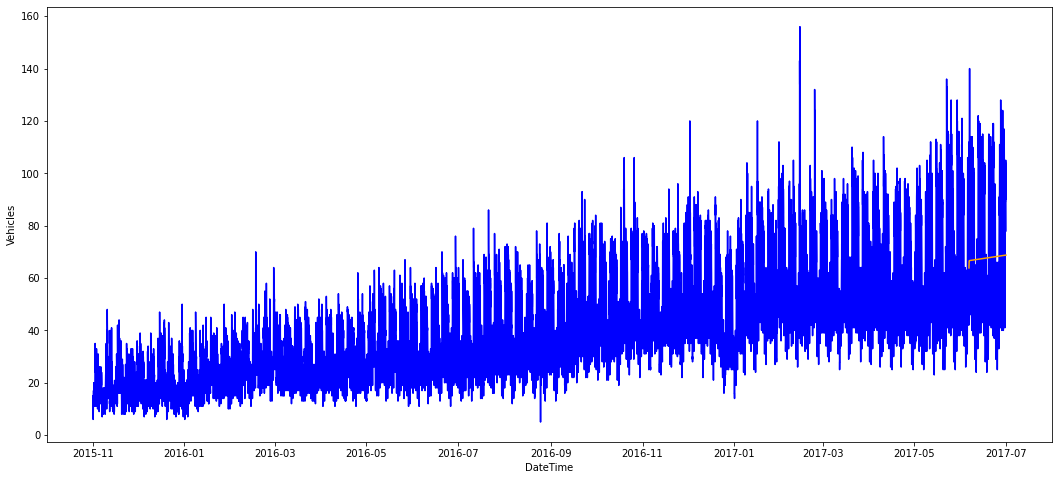

In [ ]:
plt.figure(figsize=(18,8))
sns.lineplot(data=train_j1,x='DateTime',y='Vehicles',color='blue')
sns.lineplot(x=ans.DateTime,y=preds,color='orange')

The trend is there but we haven't found other patterns.